# TP2 Logistic regression

### A few tactical imports first

In [198]:
#math tools
import numpy as np
from math import exp, log
from scipy.optimize import check_grad

#plotting
import matplotlib.pyplot as plt

#time
from time import time

## 1 Tikhonov regularization

Let us load the [dataset](http://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29#).

In [199]:
def load_cervical_cancer(filename):
    """
    reads the file, the name of which is given as an input.
    
    INPUT:
    filename = 'riskfactorscervicalcancer.csv'
    
    OUTPUT:
    X : matrix with observations as rows
    y : binary labels (1 or -1).
    """

    data = np.loadtxt(filename, delimiter=',', skiprows=1)

    # predict the testings
    y = np.max(data[:, -4:], axis=1) * 2 - 1
    # equilibrate database 
    pos_indices = np.where(y > 0)[0]
    neg_indices = np.where(y < 0)[0]
    indices = pos_indices.tolist() + neg_indices[1::7].tolist()

    y = y[indices]
    X = data[indices, :-4]

    # Standardization
    X = X - np.mean(X, axis=0)
    std_ = np.std(X, axis=0)
    X = X[:, std_ > 0]
    std_ = std_[std_ > 0]
    X = X / std_
    
    #FOR SOME REASON, THE FOLLOWING PIECE OF CODE WAS A PROBLEM FOR A COUPLE HOURS
#     # Adding the ones column to ease the expression of the intercept in the next calculi
#     Z = np.zeros((X.shape[0], X.shape[1] + 1))
#     Z[:, 0] = np.ones(X.shape[0])
#     Z[:,1:] = X 

    Z = np.c_[np.ones(X.shape[0]),X]

    return Z, y

X, y = load_cervical_cancer('riskfactorscervicalcancer.csv')

### Let us compute the value, gradient and hessian of the objective function $f$

The goal is to find $ (\omega_0^*, \omega^*) = \underset{\omega_0 \in \mathbb{R}, \omega \in \mathbb{R}^n}{arg min} f(\omega_0, \omega)$ where $$f(\omega_0, \omega) = \frac{1}{n}\sum_{i=1}^n{log\left(1+ e^{-y_i\left(x_i^T\omega+\omega_0\right)}\right)} + \frac{\rho}{2}{\|\omega\|}^2_2$$

The first step will be to simplify the expression considering: $ X' = \begin{pmatrix}
                    1 & x_1^T & \\ 
                    1 & x_2^T & \\
                    1 & \vdots & \\
                    1 & x_n^T & \\
\end{pmatrix}$, that is to say $x_i'= \begin{pmatrix}
                    1 \\
                    x_{i,1}\\ 
                    x_{i,2} \\
                    \vdots \\
                    x_{i,p} \\
\end{pmatrix}$ using also $\omega'= \begin{pmatrix}
                    \omega_{0} \\
                    \omega_{1}\\ 
                    \omega_{2} \\
                    \vdots \\
                    \omega_{p} \\
\end{pmatrix}$ and $\omega''= \begin{pmatrix}
                    0 \\
                    \omega_{1}\\ 
                    \omega_{2} \\
                    \vdots \\
                    \omega_{p} \\
\end{pmatrix}$ 

This way, we get $$f(\omega') = \frac{1}{n}\sum_{i=1}^n{log\left(1+ e^{-y_ix_i'^T\omega'}\right)} + \frac{\rho}{2}{\|\omega\|}^2_2$$

With this new notation, one can check that $\frac{d \,(x_i'^T\omega')}{d\, 
\omega_j} = x_{i,j}$. It is therefore now easy to check that 
$$\triangledown f = \rho\omega'' + \frac{1}{n}\sum_{i=1}^n{x'_i \frac{ -y_ie^{-y_ix_i'^T\omega'}}{1+e^{-y_ix_i'^T\omega'}}}$$


Computing the hessian matrix happened to be much trickier. Based on the previous result, we can write that $\frac{\partial \, f(\omega')}{\partial \, \omega_j} = \rho \omega''_j + \frac{1}{n}\sum_{i=1}^n{x'_{i,j} \frac{ -y_i \alpha}{1+\alpha}}$ where $\alpha = e^{-y_ix_i'^T\omega'}$ and $\frac{\partial \, \alpha}{\partial \, \omega_j} = -y_ix'_{i,j} \alpha$. 

This leads to finding $$\begin{split}
\left(\triangledown^2 f\right)_{j,k} &= \frac{\partial \, f(\omega')}{\partial \, \omega_j \, \omega_k} \\  
&= \rho\mathbb{1}_{= j, \neq0}(k) + \frac{1}{n}\sum_{i=1}^n{-y_i \, x'_{i,j} \frac{ \left[-y_ix'_{i,k}\right] \alpha(1+\alpha) - \left[-y_ix'_{i,k}\right]\alpha^2 }{(1+\alpha)^2}}\\  
&= \rho\mathbb{1}_{= j, \neq0}(k) + \frac{1}{n}\sum_{i=1}^n{y_i^2 \frac{\alpha }{(1+\alpha)^2}\, x'_{i,j}x'_{i,k}} \\
&= \rho\mathbb{1}_{= j, \neq0}(k) + \frac{1}{n}\sum_{i=1}^n{\beta_i\, (x')^T_{j,i}\;x'_{i,k}}
\end{split}$$ 

with $\beta_i = y_i^2 \frac{\alpha }{(1+\alpha)^2}= \frac{\alpha }{(1+\alpha)^2}$ (because $y_i^2=1$). As this clearly looks like a matrix product (something like $C=AB \Leftrightarrow \forall (j,k) \; c_{j,k}=\sum_{i=1}^{dim}{a_{j,i}b_{i,k}}$  ), we may simplify a little bit this expression noticing that 
$
\begin{pmatrix} 
\beta_1 & & & & \\ 
& \ddots & & &\\  
&  & \beta_i & &\\  
&  &  & \ddots & \\  
&  &  &  & \beta_n \\  
\end{pmatrix}
\begin{pmatrix} 
& &  & A_1 & & &\\ 
\hline
& & & \vdots\\  
\hline
& & & A_i\\  
\hline
& & &\vdots \\
\hline
& & & A_n\\  
\end{pmatrix}
=
\begin{pmatrix} 
& &  & \beta_1A_1 & & &\\ 
\hline
& & & \vdots\\  
\hline
& & & \beta_iA_i\\  
\hline
& & &\vdots \\
\hline
& & & \beta_nA_n\\  
\end{pmatrix}
$

We can deduce :
$$\triangledown^2 f = 
\rho
\begin{pmatrix} 
0 & & & \\ 
& 1 & &\\  
& & \ddots & \\  
&  &  &  1 \\  
\end{pmatrix}
+
\frac{1}{n}X'^T
\begin{pmatrix} 
\beta_1 & & & & \\ 
& \ddots & & &\\  
&  & \beta_i & &\\  
&  &  & \ddots & \\  
&  &  &  & \beta_n \\  
\end{pmatrix}
X'$$

With such an expression, the hessian matrix is clearly defined positive as $\forall i\;\beta_i >= 0$, and thus $f$ is convex

Be careful, in the code, I use both $\rho$ and $p$, which are 2 different letters ! Also, in what was written above, $\alpha$ is not a constant. It could have been written $\alpha_i$

### Checking gradient computation
Using the *check_grad* function, we will show that we had the right expression for the gradient at least for one value

In [200]:
def f(X, y, ρ, w):    
    n, p = X.shape
    if w.shape != (p,):
        print("the size of w is not compatible with X")
        return
    p = p-1
    
    #Computing the terms that are a pain in the butt in the sums only one time to use them later
    tmp = np.array([exp(-y[i] * (X[i,:].T.dot(w))) for i in range(n)])
    
    #Computing the value of the function to be minimized
    val = np.mean(np.log10(1 + tmp)) + ρ/2*(np.linalg.norm(w[1:,])**2) #be careful, ω_0 is not in the norm
    
    #Computing the gradient
    tmp2 = -y * tmp/(1+tmp)
    grad = ρ * np.concatenate(([0], w[1:,])) + 1/log(10) * np.mean(np.array([X[i,:]*tmp2[i] for i in range(n)]), axis=0) #be careful, ω_0 is not in the ρ
    
    #Computing the hessian matrix
    β = np.diagflat(tmp/((1+tmp)**2))/ log(10) #no need for y**2 as it is always equal to 1 (since (-1)**2 = 1**2 = 1)
    Im = np.eye(p+1)
    Im[0,0] = 0
    hess = ρ*Im + 1/n * X.T.dot(β.dot(X))
                
    return val, grad, hess

#Running one test
n, p = X.shape
w = np.ones(p)
ρ = 1/n
val, grad, hess = f(X, y, ρ, w)

In [201]:
def f_val(X, y, ρ, w):
    n, p = X.shape
    if w.shape != (p,):
        print("the size of w is not compatible with X")
        return
    
    #Computing the terms that are a pain in the butt in the sums only one time to use them later
    tmp = np.array([exp(-y[i] * (X[i,:].T.dot(w))) for i in range(n)])
    
    val = np.mean(np.log10(1 + tmp)) + ρ/2*(np.linalg.norm(w[1:,])**2)
    return val

def f_grad(X, y, ρ, w):
    n, p = X.shape
    if w.shape != (p,):
        print("the size of w is not compatible with X")
        return
    p = p-1
    
    #Computing the terms that are a pain in the butt in the sums only one time to use them later
    tmp = np.array([exp(-y[i] * (X[i,:].T.dot(w))) for i in range(n)])
    
    tmp2 = -y * tmp/(1+tmp)
    grad = ρ * np.concatenate(([0], w[1:,])) + 1/log(10) * np.mean(np.array([X[i,:]*tmp2[i] for i in range(n)]), axis=0)
    return grad

#generating a random vector, and computing the error made by the gradient on it
w = np.random.randint(1, size=p)
w = np.ones(p)
error = check_grad(lambda w : f_val(X, y, ρ, w), lambda w : f_grad(X, y, ρ, w), w)
print(error)

3.35030322586e-08


### Newton Technique

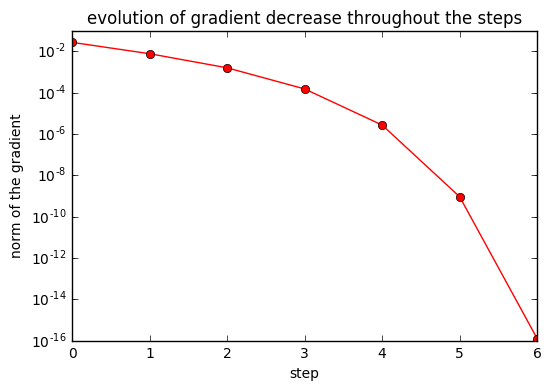

result found in 7 steps and 2.054 s 
 [ 0.13443015 -0.14877316 -0.04965737 -0.14632615  0.15942104  0.00126131
  0.18978514 -0.034097    0.08095372  0.40014913  0.13031143  0.16127294
  0.27588888  0.17200837  0.12168759  0.12168759 -0.33370843  0.14989784
  0.53755617 -0.26281755  0.46388042 -0.32751772 -0.32832466  0.32934877
  0.04689366  0.32934877  0.25266174]


In [202]:
def Newton(func, w_init, epsilon, display):
    w = w_init.copy()
    n = 0
    try:
        val , grad, hess = func(w_init)
    except OverflowError:
        print(" w is too big for the function to return something plausible")
        return
    norm = np.linalg.norm(grad)
#     print("step, value of the objective function, gradient norm")
#     print(n, "   ", val, "                 ",norm)

    if display:
        t = np.array([])
        
    while (norm > epsilon):
        w = w - np.dot(np.linalg.pinv(hess), grad)
        try:
            val, grad, hess = func(w)
        except OverflowError:
            print(" the algorithm diverges, with an overflow occuring at step %d"%(n))
            return None, None
        norm = np.linalg.norm(grad)
        n+=1
#         print(n, "   ", val, "                 ",norm)
        if display:
            t = np.append(t, norm)
    
    if display:
        plt.title("evolution of gradient decrease throughout the steps")
        plt.xlabel("step")
        plt.ylabel("norm of the gradient")
        plt.semilogy(t, 'ro-')
        plt.show()
        
    return w, n

w_init = np.zeros(p)
t = time()
w_min, n = Newton(lambda w : f(X, y, ρ, w), w_init, 1e-10, True)
print("result found in %d steps and %0.3f s \n"%(n, time() - t), w_min)

Decrease is exponential, result is found very quickly. Now let us try with another initialization

In [203]:
w_init = 0.3 * np.ones(p)
t = time()
w_min, n = Newton(lambda w : f(X, y, ρ, w), w_init, 1e-10, True)
if n != None :
    print("result found in %d steps and %d s \n"%(n, time() - t), w_min)

 the algorithm diverges, with an overflow occuring at step 7


C:\Users\Benjamin\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: overflow encountered in square


This time, the algorithm diverges, which means that the norm of w becomes so big, it causes an overflow for python. Happily, because of the exponential terms in the function tested here, we can quickly be aware of such trouble.

The fact the initializaton can lead to divergence is inherent to Newton's gradient descent technique. To suppress this effect, one can combine a line search with Newton's method, to limitate the coefficient behind the gradient so as to guarantee convergence no matter the starting $\omega$

### Newton technique + line search

After unsucessfully trying to implement a technique found in A.Astolfi course [*An introduction of Optimization*](https://drive.google.com/open?id=0B4-sjPft_IJGNXdQVEY3THFwdTg), pp.32 and 42 out of 80,

I eventually realized that:
- Armijo's line search can be applied directly along the Newtonian axis without any experimental trouble
- Somehow, the previous implementation of the gradient was not satisfying... I had to use a "for" loop to make it work. No idea why.

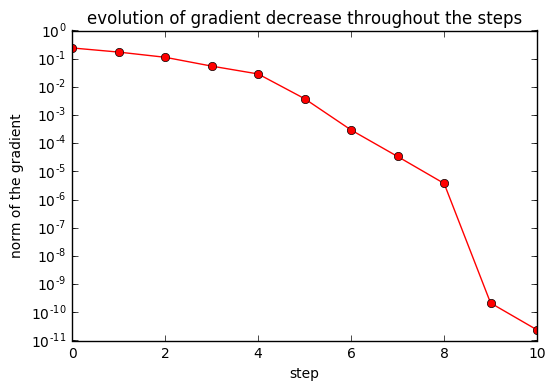

result found in 10 steps and 0.882 s 
 [ 0.13443015 -0.14877316 -0.04965737 -0.14632615  0.15942104  0.00126131
  0.18978514 -0.034097    0.08095372  0.40014913  0.13031143  0.16127294
  0.27588888  0.17200837  0.12168759  0.12168759 -0.33370843  0.14989784
  0.53755617 -0.26281755  0.46388042 -0.32751772 -0.32832466  0.32934877
  0.04689366  0.32934877  0.25266174]


In [207]:
#computes gradient with a simple "for" loop
def f_grad2(X, y, ρ, w):
    n,p = X.shape
    if w.shape != (p,):
        print("the size of w is not compatible with X")
        return

    s = 0
    for i in range(n):
        s +=  (X[i].T) * (y[i]*(np.exp(-y[i]*(X.dot(w))[i]))/(1 + np.exp(-y[i]*(X.dot(w))[i])))
    
    return ρ * np.concatenate(([0], w[1:,])) - 1/log(10) * s/n

#computes hessian with a simple "for" loop
def f_hess(X, y, ρ, w):
    n,p = X.shape
    s = np.zeros((n,n))
    for i in range(n):
         s[i,i] += (y[i])**2 * (np.exp(-y[i]*(X.dot(w))[i]))/(1 + np.exp(-y[i]*(X.dot(w))[i]))**2
    
   
    ω = np.identity(p)
    ω[0,0] = 0
    
    return ρ*ω + np.dot(np.dot(X.T,s),X)/n/log(10)

#Armijo's line search
def line_search(func, lgrad, d, w_init):
    α, β = 0.9, 1
    n, k = 0, β*d
    while func(w_init - k) >= func(w_init) - 0.5*np.dot(lgrad, k):
        n += 1
        β = β*α
        k = β*d
    return w_init - 1/α * k

#Personnalized Gradient Descent algorithm combining Newton + Armijo
def PGD(func_val, func_grad, func_hess, w_init, ϵ, display):
    w = w_init.copy()

    try:
        val , lgrad, lhess = func_val(w), func_grad(w), func_hess(w)
    except OverflowError:
        print(" w is too big for the function to return something plausible")
        return
    norm = np.linalg.norm(grad)
    
    if display:
        t = np.array([norm])
    
    
    n = 0
    while( norm > ϵ and n < 300):
        lval, lgrad, lhess = func_val(w), func_grad(w), func_hess(w)
        d = np.dot(np.linalg.inv(lhess), lgrad) #descent direction
        w = line_search(func_val, lgrad, d, w)
        norm = np.linalg.norm(lgrad)
        
        if display:
            t = np.append(t, norm)
        
#         print("step %d, f(w)= %0.12f, ||ω|| = %0.5f, ||grad_f(ω)|| = %0.12f"%(n, lval, np.linalg.norm(w), norm))
        n+=1
        
        
    if display:
        plt.title("evolution of gradient decrease throughout the steps")
        plt.xlabel("step")
        plt.ylabel("norm of the gradient")
        plt.semilogy(t, 'ro-')
        plt.show()
    
    return w, n

#trying again with troublesome initializer
# w_init = np.zeros(p)
w = 0.3*np.ones(p)
t = time()
w_min, n =  PGD(lambda w : f_val(X, y, ρ, w), lambda w : f_grad2(X, y, ρ, w), lambda w : f_hess(X, y, ρ, w), w, 1e-10, True)
print("result found in %d steps and %0.3f s \n"%(n, time() - t), w_min)

I found that the best combination for the parameters of Armijo's line search algorithm were $\alpha = 0.9$, and $\beta = 1$ (cf. code above). That is to say it is very fast, when it is almost the Newton's algorithm

## 2. Regularization using parcimony

In the new problem $$\underset{\omega' \in \mathbb{R}^{n+1}}{arg min} \; F_2(\omega') = \frac{1}{n}\sum_{i=1}^n{log\left(1+ e^{-y_ix_i'^T\omega'}\right)} + \rho{\|\omega\|}_1$$,

Newton's method cannot be used anymore as the gradient is not continuous anymore. Indeed ${\|\|}_1$ involves absolute values that are not continuous in $0$.

We can however implement a proximal gradient descent. Indeed, setting $f_2(\omega') = \frac{1}{n}\sum_{i=1}^n{log\left(1+ e^{-y_ix_i'^T\omega'}\right)}$ and $g_2(\omega') = \rho{\|\omega\|}_1$, we have $F_2 = f_2 +g_2$. Or the proximal operator of $g_2$ is simple to compute : indeed, $prox_{\gamma g_2}(x) = \underset{y \in \mathbb{R}^{n+1}}{arg min} \; g_2(y) + \frac{1}{2\gamma}{\|y -x\|}_2^2$ or this minimum argument is quite easy to find, as I will show, solving the equation $\triangledown function\_minimized\_in\_prox_{\gamma g_2}(x) = 0_{N+1 \times 1}$ is doable analitically. 

$$\begin{align*} 
    \partial \left[function\_minimized\_in\_prox(y)\right]_i &= \partial \left[\rho{\|y\|}_1 + \frac{1}{2\gamma}{\|y -x\|}_2^2\right]_i \\
    &= \left\{
            \begin{array}{ll}
                -\rho + \frac{1}{\gamma}(y_i - x_i) & \mbox{if } y_i < 0 \\
                \left[-\rho, \rho\right] + \frac{1}{\gamma}(y_i - x_i) & \mbox{if } y_i = 0 \\  
                \rho + \frac{1}{\gamma}(y_i - x_i) & \mbox{if } y_i > 0 \\
            \end{array}
        \right.
\end{align*}$$

Therefore,   
$$ \begin{align*} 
        \left[\triangledown function\_minimized\_in\_prox_{\gamma g_2}(y)\right]_i = 0 
        &\Longleftrightarrow y_i = \left\{
                                        \begin{array}{ll}
                                            \gamma\rho + x_i & \mbox{if } y_i < 0 \\
                                            \gamma\left[-\rho, \rho\right] + x_i & \mbox{if } y_i = 0 \\  
                                            x_i -\gamma\rho & \mbox{if } y_i > 0 \\
                                        \end{array}
                                    \right.\\ 
        &\Longleftrightarrow \left[prox_{\gamma g_2}(x)\right]_i = \left\{
                                        \begin{array}{ll}
                                            \gamma\rho + x_i & \mbox{if } x_i < -\gamma\rho \\
                                            0 & \mbox{if } \lvert x_i \rvert < \gamma\rho \\ 
                                            x_i -\gamma\rho & \mbox{if } x_i > \gamma\rho \\
                                        \end{array}
                                    \right.\\   
        &\Longleftrightarrow prox_{\gamma g_2}(x) = \begin{pmatrix} 
                                                        \vdots \\
                                                        \left(\gamma\rho + x_i\right)\mathbb{1}_{<0}\left(\gamma\rho + x_i\right) + \left(x_i - \gamma\rho \right)\mathbb{1}_{>0} \left(x_i - \gamma\rho\right)\\  \vdots \\  
                                                        \end{pmatrix}
\end{align*}$$

 and as before 
 $$\triangledown f_2(\omega') = \frac{1}{n}\sum_{i=1}^n{x'_i \frac{ -y_ie^{-y_ix_i'^T\omega'}}{1+e^{-y_ix_i'^T\omega'}}}$$ 
 
$$\triangledown^2 f_2(\omega') = 
\frac{1}{n}X'^T
\begin{pmatrix} 
\beta_1 & & & & \\ 
& \ddots & & &\\  
&  & \beta_i & &\\  
&  &  & \ddots & \\  
&  &  &  & \beta_n \\  
\end{pmatrix}
X'$$
 with $\beta_i = y_i^2 \frac{\alpha_i }{(1+\alpha_i)^2}= \frac{\alpha_i }{(1+\alpha_i)^2} > 0$ and $\alpha_i = e^{-y_ix_i'^T\omega'}$ and $\frac{\partial \, \alpha_i}{\partial \, \omega_j} = -y_ix'_{i,j} \alpha_i$.
 
As $\triangledown^2 g_2 = 0$, and $\triangledown^2 f_2 $ is defined positive, the objective function is still convex.
 
### proximal gradient with linear search

the stopping criterion can be the same as before : $\|\triangledown f_2(\omega')\| < \epsilon$.
I however tried something else : stop when $\|\omega_k - \omega_{k-1}\| < \epsilon$

In [257]:
def f2(X, y, w):
    n, p = X.shape
    if w.shape != (p,):
        print("the size of w is not compatible with X")
        return
    
    #Computing the terms that are a pain in the butt in the sums only one time to use them later
    tmp = np.array([exp(-y[i] * (X[i,:].T.dot(w))) for i in range(n)])
    
    val = np.mean(np.log(1 + tmp))
    return val

def f2_grad(X, y, w):
    n, p = X.shape
    if w.shape != (p,):
        print("the size of w is not compatible with X")
        return
    p = p-1
    
    #Computing the terms that are a pain in the butt in the sums only one time to use them later
    tmp = np.array([exp(-y[i] * (X[i,:].T.dot(w))) for i in range(n)])
    tmp2 = -y * tmp/(1+tmp)
    grad =  np.mean(np.array([X[i,:]*tmp2[i] for i in range(n)]), axis=0)
    
    return grad

def g2_prox_coef(x, γ, ρ):
    a = γ*ρ
    if x + a < 0:
        return x + a
    if x - a > 0:
        return x - a
    else:
        return 0

def g2_prox(x, γ, ρ):
    return np.array([g2_prox_coef(xi, γ, ρ) for xi in x])

def prox_search(f, f_grad, g_prox, x0, ϵ, a, b):
    x = x0.copy()
    lfunc, lgrad = f(x), f_grad(x)
    norm = np.linalg.norm(lgrad)
    n, γ = 0, b
    e=1
    while e > ϵ and n < 500:
        xx = g_prox(x - γ*lgrad, γ)
        while f(xx) > lfunc + np.dot(lgrad.T, xx-x) + 1/(2*γ)*(np.linalg.norm(x-xx)**2):
#         while f(xx) > lfunc + np.dot(lgrad.T, xx-x) + 0.5*np.dot(lgrad, (xx-x)):
            γ = γ * a
            xx = g2_prox(x - γ*lgrad, γ, ρ)
        
        e = np.linalg.norm(x-xx)
        
        if γ != b :
            x = g2_prox(x - γ/a*lgrad, γ/a, ρ)
        else:
            x = g2_prox(x - γ*lgrad, γ, ρ)
            
        lfunc, lgrad = f(x), f_grad(x)
        γ = b
        
        n+=1
        norm = np.linalg.norm(lgrad)
        
        
#         print("n= %d, func_norm = %0.5f, grad_norm = %0.12f, γ= %0.7f"%(n, lfunc, norm, γ))
        
    return x, n

#executing the line search
ρ = 0.1
w_init = 0.3*np.ones(p)
t = time()
w_min2, n = prox_search(lambda w : f2(X, y, w), 
                     lambda w : f2_grad(X, y, w), 
                     lambda x, γ : g2_prox(x, γ, ρ), 
                     w_init, 
                     1e-10, 
                     0.5, 1)
print("result found in %d steps and %d s \n"%(n, time() - t), w_min2)

result found in 390 steps and 1 s 
 [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.0047856
  0.          0.          0.          0.          0.          0.          0.0077993
  0.          0.          0.01812763  0.          0.01812763  0.        ]


## Conclusion
- The first problem was a $l_2$ regularization. It is supposed to allow for a greater error minimization for the original problem. As it was convex and differentiable, we could use Newton technique for gradient descent.
- The second problem was a $l_1$ regularization. It is supposed to perform better feature selection (and thus nullify a greater number of numbers in $\omega'$). This time, we had to use the proximal gradient technique as it was not continuously differentiable anymore.

Below is displayed with the same $\rho$ the tolerance per coefficient by the laplacian model aka $l_1$, and the gaussian model, aka $l_2$
![pic](https://qph.ec.quoracdn.net/main-qimg-5784bbc04988b7f4a8321468c42bb752)

This shows that $l_1$ supports both high coefficients and $0$ better than $l_2$, and is therefore useful in case of sparse features.

It can be understood even better with this well-known chart, considering the horizontal axis, and the fact that the edges of the square representing $l_1$ penalization are more stretched than the circle representing $l_2$ penalization when $x \in \{0, \mbox{big number}\}$
![pic2](https://qph.ec.quoracdn.net/main-qimg-0c3170db58ecb02184c794cef75539e8-c)

[source](https://www.quora.com/What-is-the-difference-between-L1-and-L2-regularization)